In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import loguniform
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import CondensedNearestNeighbour 
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.utils import resample

# Import Data

In [2]:
df = pd.read_csv('dataset/dataCOMP0050Coursework1.csv')

In [3]:
df.shape

(8929, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8929 entries, 0 to 8928
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             8929 non-null   int64  
 1   term                  8929 non-null   int64  
 2   installment           8929 non-null   float64
 3   emp_length            8504 non-null   float64
 4   home_ownership        8929 non-null   object 
 5   verification_status   8929 non-null   object 
 6   issue_d               8929 non-null   object 
 7   purpose               8929 non-null   object 
 8   dti                   8929 non-null   float64
 9   earliest_cr_line      8929 non-null   int64  
 10  open_acc              8929 non-null   int64  
 11  pub_rec               8929 non-null   int64  
 12  revol_util            8915 non-null   float64
 13  total_acc             8929 non-null   int64  
 14  application_type      8929 non-null   object 
 15  mort_acc             

In [5]:
df.head()

,loan_amnt,term,installment,emp_length,home_ownership,verification_status,issue_d,purpose,dti,earliest_cr_line,...,pub_rec,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off
0,5675,36,189.56,2.0,RENT,Source Verified,14-Dec,car,15.55,1992,...,0,15.0,15,Individual,0.0,0.0,4.698979,697.0,3.464936,0
1,7000,36,242.63,1.0,RENT,Source Verified,14-Dec,car,6.78,2002,...,0,69.2,5,Individual,0.0,0.0,4.301052,717.0,3.431364,0
2,3500,36,116.24,10.0,MORTGAGE,Not Verified,14-Dec,car,10.65,1997,...,0,12.6,35,Individual,2.0,0.0,4.681250,742.0,3.765520,0
3,10000,36,316.47,10.0,MORTGAGE,Not Verified,14-Dec,car,21.74,1996,...,0,23.7,22,Individual,4.0,0.0,4.875067,707.0,3.424555,0
4,1500,36,46.31,2.0,OWN,Not Verified,14-Dec,car,12.17,1997,...,0,46.5,13,Individual,2.0,0.0,4.812920,712.0,4.448211,0


In [6]:
df.columns

Index(['loan_amnt', 'term', 'installment', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'purpose', 'dti', 'earliest_cr_line',
       'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'log_annual_inc', 'fico_score',
       'log_revol_bal', 'charged_off'],
      dtype='object')

# Data Analysis

To analysis the staitsical property of features available in the dataset for further feature engineering process.
Sayah (2021) gave a great example to analysis the data of p2p lending data. However, the origianal dataset contains many features that our dataset doesn't have. So subset of his analysis techniques will be reused to support this report. URL: https://www.kaggle.com/faressayah/lending-club-loan-defaulters-prediction

/home/null/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='charged_off', ylabel='count'>

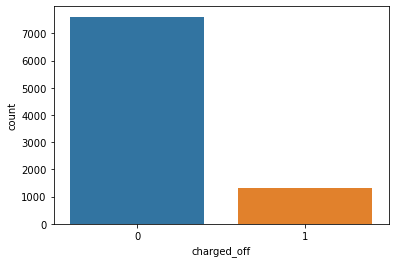

In [7]:
# To see data points grouped by target variable 'charged_off'
sns.countplot(df.charged_off)

In [8]:
df.charged_off.value_counts()

0    7608
1    1321
Name: charged_off, dtype: int64

The analysis shows that data is unblanced with default labelled of 1321 but non-default has 7608 rows. So we need to handle this unbalanced dataset carefully. 

<AxesSubplot:>

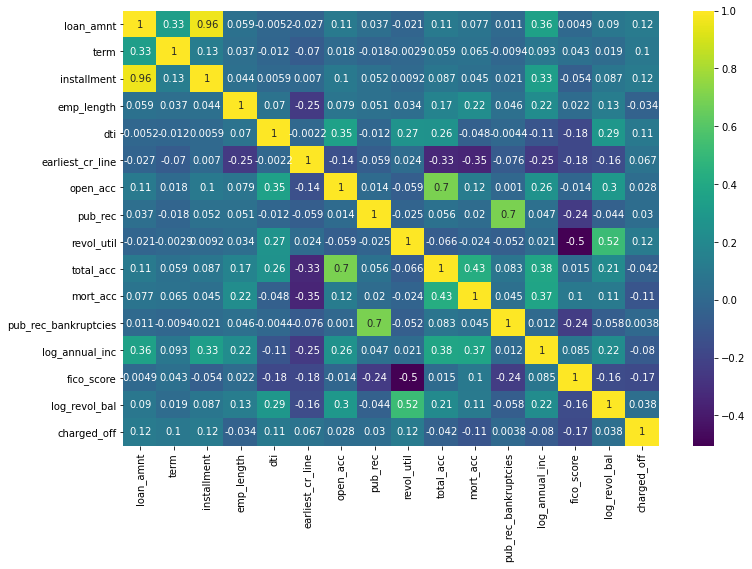

In [9]:
# Plot the installment and loan_amnt features against charged_off variable
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

<AxesSubplot:>

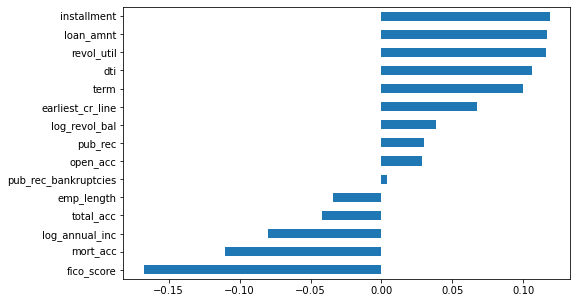

In [10]:
# How numeric features correlate with the target variable?
plt.figure(figsize=(8, 5))
df.corr()['charged_off'].drop('charged_off').sort_values().plot(kind='barh')

The correlation plot shows that there are no features that shows a strong positive or negative correaltion agaist charged_off feature. All features (except charged_off itself) have low correlation value less than 0.5 or -0.5. <br> 
However, there is a strong correation between few training features such as loan_amnt and installment with value of 0.96 which shows (almost) perfect positive correlation. This is an expected relationship as the lender decides the installment corresponding to the loan amount. 

<AxesSubplot:xlabel='charged_off', ylabel='loan_amnt'>

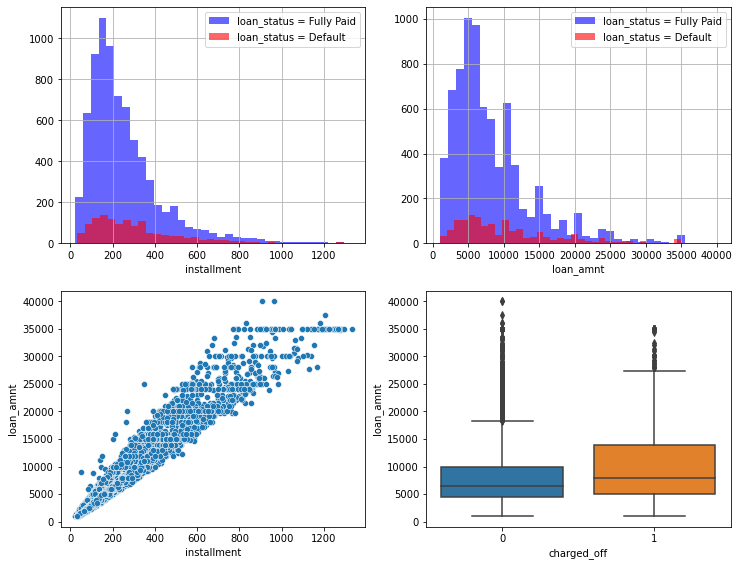

In [11]:
# there is a high correlation (almost perfect) between installment and loan amount
plt.figure(figsize=(12, 20))

plt.subplot(4, 2, 1)
df[df["charged_off"] == 0]["installment"].hist(bins=35, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["installment"].hist(bins=35, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("installment")

plt.subplot(4, 2, 2)
df[df["charged_off"] == 0]["loan_amnt"].hist(bins=35, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["loan_amnt"].hist(bins=35, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("loan_amnt")

plt.subplot(4, 2, 3)
sns.scatterplot(x='installment', y='loan_amnt', data=df)

plt.subplot(4, 2, 4)
sns.boxplot(x='charged_off', y='loan_amnt', data=df)

In [12]:
df.groupby(by='charged_off')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
charged_off,,,,,,,,
0,7608.0,8294.601078,5784.174129,1000.0,4500.0,6500.0,10000.0,40000.0
1,1321.0,10282.021196,7222.812949,1000.0,5000.0,8000.0,14000.0,35000.0


When the lender issue the loan, they always consider the annual income of borrower, length of employments as critical factors.

Text(0.5, 0, 'log_annual_inc')

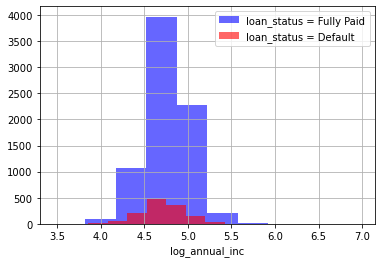

In [13]:
df[df["charged_off"] == 0]["log_annual_inc"].hist(bins=10, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["log_annual_inc"].hist(bins=10, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("log_annual_inc")

Text(0.5, 0, 'emp_length')

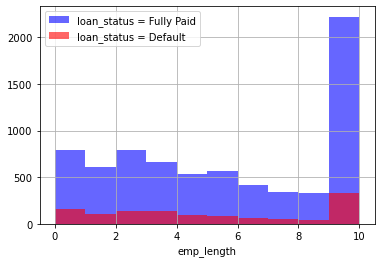

In [14]:
df[df["charged_off"] == 0]["emp_length"].hist(bins=10, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["emp_length"].hist(bins=10, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("emp_length")

In [15]:
df[df.emp_length.isnull()].shape

(425, 21)

Surprisingly, there are 425 rows have null value for emp_length.

Now, lookinng other other numerical attributes that may affect the charged_off prediction

Text(0.5, 0, 'fico_score')

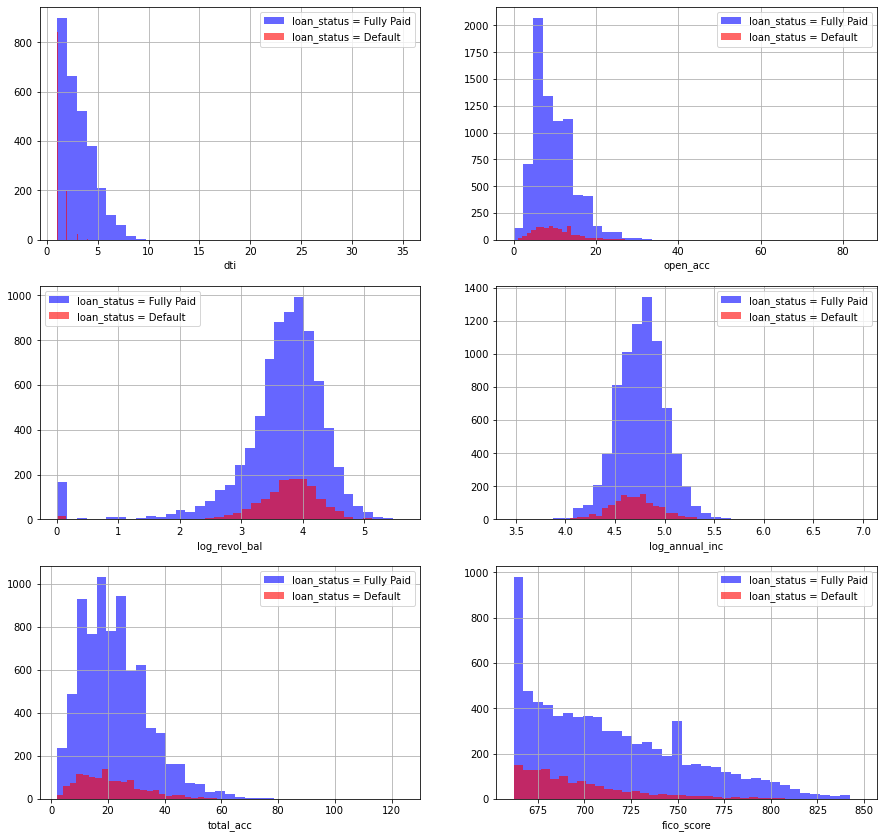

In [16]:
plt.figure(figsize=(15, 30))

plt.subplot(6, 2, 1)
df[df["charged_off"] == 0]["dti"].value_counts().hist(bins=35, color='blue', 
                                                                     label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["dti"].value_counts().hist(bins=35, color='red', 
                                                                      label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("dti")

plt.subplot(6, 2, 2)
df[df["charged_off"] == 0]["open_acc"].hist(bins=35, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["open_acc"].hist(bins=35, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("open_acc")

plt.subplot(6, 2, 3)
df[df["charged_off"] == 0]["log_revol_bal"].hist(bins=35, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["log_revol_bal"].hist(bins=35, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("log_revol_bal")

plt.subplot(6, 2, 4)
df[df["charged_off"] == 0]["log_annual_inc"].hist(bins=35, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["log_annual_inc"].hist(bins=35, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("log_annual_inc")

plt.subplot(6, 2, 5)
df[df["charged_off"] == 0]["total_acc"].hist(bins=35, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["total_acc"].hist(bins=35, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("total_acc")

plt.subplot(6, 2, 6)
df[df["charged_off"] == 0]["fico_score"].hist(bins=35, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["fico_score"].hist(bins=35, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()
plt.xlabel("fico_score")

<AxesSubplot:xlabel='pub_rec_bankruptcies', ylabel='count'>

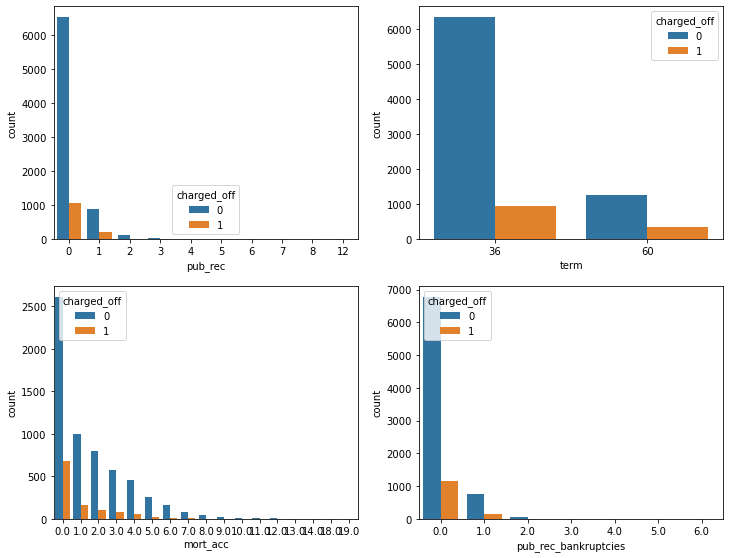

In [17]:
plt.figure(figsize=(12, 30))

plt.subplot(6, 2, 1)
sns.countplot(x='pub_rec', data=df, hue='charged_off')

plt.subplot(6, 2, 2)
sns.countplot(x='term', data=df, hue='charged_off')

plt.subplot(6, 2, 3)
sns.countplot(x='mort_acc', data=df, hue='charged_off')

plt.subplot(6, 2, 4)
sns.countplot(x='pub_rec_bankruptcies', data=df, hue='charged_off')

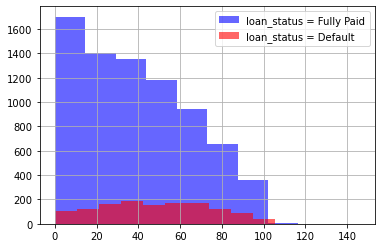

In [18]:
df[df["charged_off"] == 0]["revol_util"].hist(bins=10, color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1]["revol_util"].hist(bins=10, color='red', label='loan_status = Default', alpha=0.6)
plt.legend()

From the previous correlation plot, it doesn't show the correlation of the categorical features. So we should look on the relationship between these features and charged_off variable

In [19]:
# Shows the categorical columns
df.describe(include=['O'])

,home_ownership,verification_status,issue_d,purpose,application_type
count,8929,8929,8929,8929,8929
unique,3,3,120,1,2
top,RENT,Not Verified,14-Oct,car,Individual
freq,4011,4006,269,8929,8908


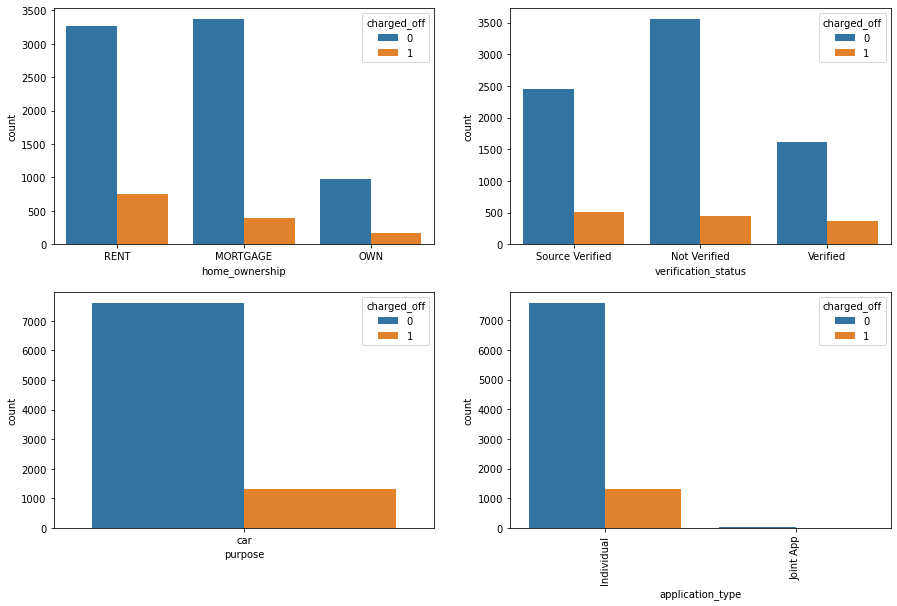

In [20]:
# visualisation of categorical columns (except issue_d)
plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sns.countplot(x='home_ownership', data=df, hue='charged_off')

plt.subplot(4, 2, 2)
sns.countplot(x='verification_status', data=df, hue='charged_off')

plt.subplot(4, 2, 3)
sns.countplot(x='purpose', data=df, hue='charged_off')

plt.subplot(4, 2, 4)
g = sns.countplot(x='application_type', data=df, hue='charged_off')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

Now we notice that the purpose column has only one value of 'car' so we can disregard during feature engineering process.

Issue_d was marked as categorical type as it contains an object of timestamp with month and year. We can visualise the count of fully paid and default loan by extracting year. Similar to earliest_cr_line column which contain numerical value of year. 

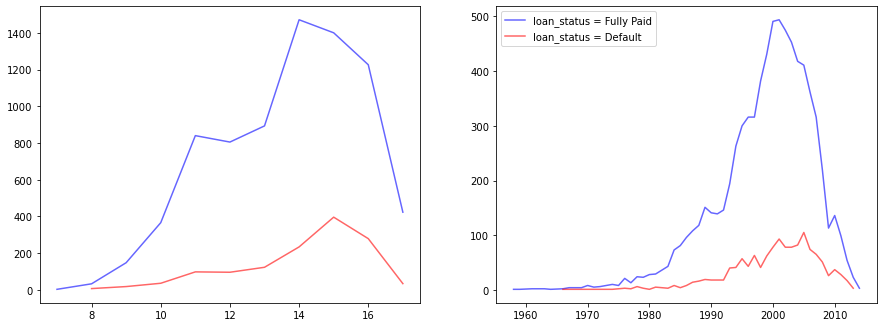

In [21]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
df[df["charged_off"] == 0].issue_d.str.split('-').str[0].astype(int).value_counts().sort_index().plot(color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1].issue_d.str.split('-').str[0].astype(int).value_counts().sort_index().plot(color='red', label='loan_status = Default', alpha=0.6)

plt.subplot(2, 2, 2)
df[df["charged_off"] == 0].earliest_cr_line.value_counts().sort_index().plot(color='blue', label='loan_status = Fully Paid', alpha=0.6)
df[df["charged_off"] == 1].earliest_cr_line.value_counts().sort_index().plot(color='red', label='loan_status = Default', alpha=0.6)

plt.legend()

There is a peak between 2014 and 2016 that for defaulting loan based on issue_d. However, we should not consider this issue_d into our prediction model because it doesn't give any significant value when we use the model to classify new input with latest issue_d.

Meanwhile, earliest_cr_line should be taken into account as it tell when borrower's earliest reported credit line was opened  

Overall, there are two types of features available for this dataset. There are features that related to applicants such as length of employment and feature of loan characteristics, e.g., total amount of loan. 

# Data Preprocessing

## Missing Data handling

In [22]:
def show_missing(df):
    for column in df.columns:
        if df[column].isnull().sum() != 0:
            total_missing = df[column].isna().sum()
            portion = (total_missing / df.shape[0]) * 100
            print(f"'{column}': number of missing values '{total_missing}' ==> '{portion:.3f}%'")

In [23]:
show_missing(df)

'emp_length': number of missing values '425' ==> '4.760%'
'revol_util': number of missing values '14' ==> '0.157%'
'mort_acc': number of missing values '1756' ==> '19.666%'
'pub_rec_bankruptcies': number of missing values '17' ==> '0.190%'


There are 4 columns with missing values.

In [24]:
# Fill missing emp_length with zero value
df['emp_length'].fillna(0, inplace = True)

To handle mort_acc, we look at the earlier correlation table which shows a positive correlation value of 0.43 with total_acc. To fill missing value, we will use the mean group by total_acc feature.

In [25]:
total_acc_avg = df.groupby(by='total_acc').mean().mort_acc

In [26]:
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

In [27]:
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [28]:
# Check if there is any missing data
df.mort_acc.isnull().sum()

0

revol_util and pub_rec_bankruptcies columns also have missing data. Both columns have missing values which count less than 0.20% of dataset. We can safely remove missing rows from dataset.

In [29]:
show_missing(df)

'revol_util': number of missing values '14' ==> '0.157%'
'pub_rec_bankruptcies': number of missing values '17' ==> '0.190%'


In [30]:
df.dropna(inplace=True)

In [31]:
# Check if there is any column has missing values
df.isnull().sum()

loan_amnt               0
term                    0
installment             0
emp_length              0
home_ownership          0
verification_status     0
issue_d                 0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_util              0
total_acc               0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
log_annual_inc          0
fico_score              0
log_revol_bal           0
charged_off             0
dtype: int64

In [32]:
df.shape

(8898, 21)

The data is reduced to 8898 from 8929 rows

## Categorical data handling

In [33]:
list(df.describe(include=['O']).columns)

['home_ownership',
 'verification_status',
 'issue_d',
 'purpose',
 'application_type']

Every rows has the same purpose 'car' value so we can safely remove this column from the dataset as it will not affect the default loan prediction.

In [34]:
df.purpose.value_counts()

car    8898
Name: purpose, dtype: int64

In [35]:
df.drop('purpose', axis=1, inplace=True)

In [36]:
# number of features remove from 20 to 19 with the same total rows
df.shape

(8898, 20)

As explained previously, we should not consider issue date of loan. This column will be dropped. 

In [37]:
df.drop('issue_d', axis=1, inplace=True)

df.shape

(8898, 19)

In [38]:
# Reset Index of dataFrame
df.reset_index(drop=True, inplace=True)

There are other three categorical features, i.e., home_ownership, verification_status and application_type. There are two techniques can be used to converted text data to numberical value such as LabelEncoder and OneHotEncoder.

In [39]:
# # LabelEncoder - The matrix gives lower value than OneHotEncoder technique
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()

# df['home_ownership'] = encoder.fit_transform(df['home_ownership'])
# df['verification_status'] = encoder.fit_transform(df['verification_status'])
# df['application_type'] = encoder.fit_transform(df['application_type'])

In [40]:
# OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# verification_status
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(df[['verification_status']]).toarray())

enc_df.columns = ['verification_status_0', 'verification_status_1', 'verification_status_2']
enc_df.head()

df = df.join(enc_df)
df.head()

,loan_amnt,term,installment,emp_length,home_ownership,verification_status,dti,earliest_cr_line,open_acc,pub_rec,...,application_type,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off,verification_status_0,verification_status_1,verification_status_2
0,5675,36,189.56,2.0,RENT,Source Verified,15.55,1992,7,0,...,Individual,0.0,0.0,4.698979,697.0,3.464936,0,0.0,1.0,0.0
1,7000,36,242.63,1.0,RENT,Source Verified,6.78,2002,3,0,...,Individual,0.0,0.0,4.301052,717.0,3.431364,0,0.0,1.0,0.0
2,3500,36,116.24,10.0,MORTGAGE,Not Verified,10.65,1997,16,0,...,Individual,2.0,0.0,4.681250,742.0,3.765520,0,1.0,0.0,0.0
3,10000,36,316.47,10.0,MORTGAGE,Not Verified,21.74,1996,7,0,...,Individual,4.0,0.0,4.875067,707.0,3.424555,0,1.0,0.0,0.0
4,1500,36,46.31,2.0,OWN,Not Verified,12.17,1997,8,0,...,Individual,2.0,0.0,4.812920,712.0,4.448211,0,1.0,0.0,0.0


In [41]:
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(df[['home_ownership']]).toarray())

# home_ownership
enc_df.columns = ['home_ownership_0', 'home_ownership_1', 'home_ownership_2']
enc_df.head()

df = df.join(enc_df)
df.head()

,loan_amnt,term,installment,emp_length,home_ownership,verification_status,dti,earliest_cr_line,open_acc,pub_rec,...,log_annual_inc,fico_score,log_revol_bal,charged_off,verification_status_0,verification_status_1,verification_status_2,home_ownership_0,home_ownership_1,home_ownership_2
0,5675,36,189.56,2.0,RENT,Source Verified,15.55,1992,7,0,...,4.698979,697.0,3.464936,0,0.0,1.0,0.0,0.0,0.0,1.0
1,7000,36,242.63,1.0,RENT,Source Verified,6.78,2002,3,0,...,4.301052,717.0,3.431364,0,0.0,1.0,0.0,0.0,0.0,1.0
2,3500,36,116.24,10.0,MORTGAGE,Not Verified,10.65,1997,16,0,...,4.681250,742.0,3.765520,0,1.0,0.0,0.0,1.0,0.0,0.0
3,10000,36,316.47,10.0,MORTGAGE,Not Verified,21.74,1996,7,0,...,4.875067,707.0,3.424555,0,1.0,0.0,0.0,1.0,0.0,0.0
4,1500,36,46.31,2.0,OWN,Not Verified,12.17,1997,8,0,...,4.812920,712.0,4.448211,0,1.0,0.0,0.0,0.0,1.0,0.0


In [42]:
enc = OneHotEncoder ()
enc_df = pd.DataFrame(enc.fit_transform(df[['application_type']]).toarray())

#application_type
enc_df.columns = ['application_type_0', 'application_type_1']
enc_df.head()

df = df.join(enc_df)
df.head()

,loan_amnt,term,installment,emp_length,home_ownership,verification_status,dti,earliest_cr_line,open_acc,pub_rec,...,log_revol_bal,charged_off,verification_status_0,verification_status_1,verification_status_2,home_ownership_0,home_ownership_1,home_ownership_2,application_type_0,application_type_1
0,5675,36,189.56,2.0,RENT,Source Verified,15.55,1992,7,0,...,3.464936,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,7000,36,242.63,1.0,RENT,Source Verified,6.78,2002,3,0,...,3.431364,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,3500,36,116.24,10.0,MORTGAGE,Not Verified,10.65,1997,16,0,...,3.765520,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10000,36,316.47,10.0,MORTGAGE,Not Verified,21.74,1996,7,0,...,3.424555,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1500,36,46.31,2.0,OWN,Not Verified,12.17,1997,8,0,...,4.448211,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [43]:
# Drop the original categorical columns
categorical_columns = list(df.describe(include=['O']).columns) 
df.drop(categorical_columns, axis=1, inplace=True)

In [44]:
# Reset Index of dataFrame
df.reset_index(drop=True, inplace=True)

In [45]:
df.head()

,loan_amnt,term,installment,emp_length,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,...,log_revol_bal,charged_off,verification_status_0,verification_status_1,verification_status_2,home_ownership_0,home_ownership_1,home_ownership_2,application_type_0,application_type_1
0,5675,36,189.56,2.0,15.55,1992,7,0,15.0,15,...,3.464936,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,7000,36,242.63,1.0,6.78,2002,3,0,69.2,5,...,3.431364,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,3500,36,116.24,10.0,10.65,1997,16,0,12.6,35,...,3.765520,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10000,36,316.47,10.0,21.74,1996,7,0,23.7,22,...,3.424555,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1500,36,46.31,2.0,12.17,1997,8,0,46.5,13,...,4.448211,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [46]:
df.shape

(8898, 24)

## Duplicate Data

In [47]:
print(f"Data shape: {df.shape}")

# Remove duplicate Features
df = df.T.drop_duplicates()
df = df.T

# Remove Duplicate Rows
df.drop_duplicates(inplace=True)

print(f"Data shape: {df.shape}")

Data shape: (8898, 24)
Data shape: (8898, 24)


There is no duplicate datat points

# Unbalanced Dataset With Random Forest

Now we want to apply simple Random Forest model to see the performance of defaulting classification on unbalanced dataset.

In [48]:
non_default_prop = df.charged_off.value_counts()[0] / df.shape[0]
default_prop = df.charged_off.value_counts()[1] / df.shape[0]

print(f"Non-Defaulting {non_default_prop}")
print(f"Defaulting {default_prop}")

Non-Defaulting 0.8522139806698135
Defaulting 0.14778601933018656


In [49]:
X = df.drop('charged_off', axis=1)
y = df.charged_off

#Train 90% and Test 10% of dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8008, 23)
(890, 23)
(8008,)
(890,)


In [50]:
# Normalise the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [51]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

In [52]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        print("_______________________________________________")
        print(f"AUC: \n {roc_auc_score(true, pred)}\n")
        print(f"Accuracy: \n {accuracy_score(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        print("_______________________________________________")
        print(f"AUC: \n {roc_auc_score(true, pred)}\n")
        print(f"Accuracy: \n {accuracy_score(true, pred)}\n")

In [53]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Classification Report:
              0.0     1.0  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    6808.0  1200.0       1.0     8008.0        8008.0
_______________________________________________
Confusion Matrix: 
 [[6808    0]
 [   0 1200]]

_______________________________________________
AUC: 
 1.0

Accuracy: 
 1.0

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.872460    0.500000  0.870787    0.686230      0.824334
recall       0.997419    0.017391  0.870787    0.507405      0.870787
f1-score     0.930765    0.033613  0.870787    0.482189      0.814841
support    775.000000  115.000000  0.870787  890.000000    890.000000
_______________________________________________
Confusion Matrix: 
 [[773   2]
 [113   2]]

_______

# Balanced Dataset

The above result shows that the model underperform on unbalanced dataset as expected. So we need to balance training dataset before feeding to classification model. There are various technique can be used. One is the oversampling techniques, using Boyle's code (2019). URL: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18 and SMOTE technique. The code of oversampling can be undo and comment SMOTE code part to run the model with oversampling technique.

In [54]:
X = df.drop('charged_off', axis=1)
y = df.charged_off

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0, shuffle=True)
y_train.value_counts()

0.0    6808
1.0    1200
Name: charged_off, dtype: int64

In [55]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0, sampling_strategy=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)
y_train.value_counts()

1.0    6808
0.0    6808
Name: charged_off, dtype: int64

In [56]:
# # Combine training dataset with target variable 'charged_off' from y_train
# train = pd.concat([X_train, y_train], axis=1)

# non_default = train[train.charged_off==0]
# default = train[train.charged_off==1]

# # upsample minority to match the number of majority class (non_default)
# default_upsampled = resample(default,
#                           replace=True, 
#                           n_samples=len(non_default),
#                           random_state=0) 

# # combine non_default and upsampled default
# upsampled = pd.concat([non_default, default_upsampled])

# print(upsampled.charged_off.value_counts())

# # separate to X and y of training dataset
# X_train = upsampled.drop('charged_off', axis=1)
# y_train = upsampled.charged_off

In [57]:
# Normalise data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [58]:
# Without grid search
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Classification Report:
              0.0     1.0  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    6808.0  6808.0       1.0    13616.0       13616.0
_______________________________________________
Confusion Matrix: 
 [[6808    0]
 [   0 6808]]

_______________________________________________
AUC: 
 1.0

Accuracy: 
 1.0

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.879310    0.500000  0.870787    0.689655      0.830298
recall       0.987097    0.086957  0.870787    0.537027      0.870787
f1-score     0.930091    0.148148  0.870787    0.539120      0.829054
support    775.000000  115.000000  0.870787  890.000000    890.000000
_______________________________________________
Confusion Matrix: 
 [[765  10]
 [105  10]]

_______

# Logistics Regression

In [59]:
model = LogisticRegression()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

search = RandomizedSearchCV(model, space, n_iter=1000, scoring='f1', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.6838191057715647
Best Hyperparameters: {'C': 42.93807693006186, 'penalty': 'l2', 'solver': 'lbfgs'}


/home/null/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
best_estimator = result.best_estimator_
best_C = result.best_params_['C']
best_penalty = result.best_params_['penalty']
best_solver = result.best_params_['solver']

In [61]:
logreg = LogisticRegression(C = best_C, penalty = best_penalty, solver = best_solver)
logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)
y_pred = logreg.predict(X_test)

/home/null/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Classification Report:
                   0.0          1.0  accuracy     macro avg  weighted avg
precision     0.686139     0.664362  0.674574      0.675251      0.675251
recall        0.643508     0.705640  0.674574      0.674574      0.674574
f1-score      0.664140     0.684379  0.674574      0.674260      0.674260
support    6808.000000  6808.000000  0.674574  13616.000000  13616.000000
_______________________________________________
Confusion Matrix: 
 [[4381 2427]
 [2004 4804]]

_______________________________________________
AUC: 
 0.6745740305522914

Accuracy: 
 0.6745740305522914

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.929924    0.215470  0.639326    0.572697      0.837607
recall       0.633548    0.678261  0.639326    0.655905      0.639326
f1-score     0.753645    0.327044  0.639326    0.540345      0.698523
support    775.000000  115.000000  0.639326  890.000000    890.000000
____

In [63]:
# change of threshold from 0.5 to another threshold
threshold = 0.45

logreg = LogisticRegression(C = best_C, penalty = best_penalty, solver = best_solver)
logreg.fit(X_train, y_train)
predicted_proba = logreg.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

print_score(y_train, y_train_pred, train=True)
print_score(y_test, predicted, train=False)

Train Result:
Classification Report:
                   0.0          1.0  accuracy     macro avg  weighted avg
precision     0.686139     0.664362  0.674574      0.675251      0.675251
recall        0.643508     0.705640  0.674574      0.674574      0.674574
f1-score      0.664140     0.684379  0.674574      0.674260      0.674260
support    6808.000000  6808.000000  0.674574  13616.000000  13616.000000
_______________________________________________
Confusion Matrix: 
 [[4381 2427]
 [2004 4804]]

_______________________________________________
AUC: 
 0.6745740305522914

Accuracy: 
 0.6745740305522914

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.943478    0.206977   0.58764    0.575228      0.848312
recall       0.560000    0.773913   0.58764    0.666957      0.587640
f1-score     0.702834    0.326606   0.58764    0.514720      0.654220
support    775.000000  115.000000   0.58764  890.000000    890.000000
____

/home/null/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Decision Tree

In [64]:
model = DecisionTreeClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
space = dict({
    "criterion": ['gini', 'entropy'],
    "max_depth": range(1, 10),
    "min_samples_split": range(1, 10),
    "min_samples_leaf": range(1, 5)
})

search = RandomizedSearchCV(model, space, n_iter=1000, scoring='f1', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/home/null/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 648 is smaller than n_iter=1000. Running 648 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Score: 0.8261288577487734
Best Hyperparameters: {'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 9, 'criterion': 'gini'}


In [65]:
best_estimator = result.best_estimator_
best_min_samples_split = result.best_params_['min_samples_split']
best_min_samples_leaf = result.best_params_['min_samples_leaf']
best_max_depth = result.best_params_['max_depth']
best_criterion = result.best_params_['criterion']

In [66]:
decision_tree = DecisionTreeClassifier(criterion=best_criterion, max_depth = best_max_depth, min_samples_leaf= best_min_samples_leaf, min_samples_split= best_min_samples_split)
decision_tree.fit(X_train, y_train)

y_train_pred = decision_tree.predict(X_train)
y_pred = decision_tree.predict(X_test)

In [67]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Classification Report:
                   0.0          1.0  accuracy     macro avg  weighted avg
precision     0.801929     0.955592  0.863176      0.878761      0.878761
recall        0.964600     0.761751  0.863176      0.863176      0.863176
f1-score      0.875775     0.847732  0.863176      0.861754      0.861754
support    6808.000000  6808.000000  0.863176  13616.000000  13616.000000
_______________________________________________
Confusion Matrix: 
 [[6567  241]
 [1622 5186]]

_______________________________________________
AUC: 
 0.8631756756756757

Accuracy: 
 0.8631756756756757

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.872771    0.163265  0.833708    0.518018      0.781093
recall       0.947097    0.069565  0.833708    0.508331      0.833708
f1-score     0.908416    0.097561  0.833708    0.502988      0.803642
support    775.000000  115.000000  0.833708  890.000000    890.000000
____

# Random Forest

In [68]:
model = RandomForestClassifier()

n_estimators = [100, 500, 1000]
max_depth = [3, 5, 8]
max_features = ["sqrt", 0.5]
space = dict(
    n_estimators = n_estimators,
    max_depth = max_depth,  
    max_features = max_features
)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
search = GridSearchCV(model, space, scoring='f1', n_jobs=-1, cv=cv)
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8602399740832217
Best Hyperparameters: {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 1000}


In [69]:
best_estimator = result.best_estimator_
best_n_estimators = result.best_params_['n_estimators']
best_max_depth = result.best_params_['max_depth']
best_max_features = result.best_params_['max_features']

In [70]:
random_forest = RandomForestClassifier(
    n_estimators = best_n_estimators,
    class_weight='balanced',
    max_depth = best_max_depth,
    max_features = best_max_features
)
random_forest.fit(X_train, y_train)

y_train_pred = random_forest.predict(X_train)
y_pred = random_forest.predict(X_test)

In [71]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Classification Report:
                   0.0          1.0  accuracy     macro avg  weighted avg
precision     0.828568     0.959486  0.883152      0.894027      0.894027
recall        0.966216     0.800088  0.883152      0.883152      0.883152
f1-score      0.892114     0.872567  0.883152      0.882340      0.882340
support    6808.000000  6808.000000  0.883152  13616.000000  13616.000000
_______________________________________________
Confusion Matrix: 
 [[6578  230]
 [1361 5447]]

_______________________________________________
AUC: 
 0.8831521739130435

Accuracy: 
 0.8831521739130435

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.884161    0.386364  0.859551    0.635262      0.819839
recall       0.965161    0.147826  0.859551    0.556494      0.859551
f1-score     0.922887    0.213836  0.859551    0.568362      0.831268
support    775.000000  115.000000  0.859551  890.000000    890.000000
____

# SVM

In [72]:
model = svm.SVC()

kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
space = dict(kernel=kernel,C=C,gamma=gamma)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

search = GridSearchCV(model, space, scoring='f1', n_jobs=-1, cv=cv)
result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.837401932071593
Best Hyperparameters: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}


In [73]:
best_estimator = result.best_estimator_
best_C = result.best_params_['C']
best_gamma = result.best_params_['gamma']
best_kernel = result.best_params_['kernel']

In [74]:
clf = svm.SVC(C = best_C, gamma = best_gamma, kernel = best_kernel, probability=True)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

In [75]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred, train=False)

Train Result:
Classification Report:
                   0.0          1.0  accuracy     macro avg  weighted avg
precision     0.809193     0.968415  0.872503      0.888804      0.888804
recall        0.974882     0.770123  0.872503      0.872503      0.872503
f1-score      0.884344     0.857961  0.872503      0.871152      0.871152
support    6808.000000  6808.000000  0.872503  13616.000000  13616.000000
_______________________________________________
Confusion Matrix: 
 [[6637  171]
 [1565 5243]]

_______________________________________________
AUC: 
 0.8725029377203289

Accuracy: 
 0.872502937720329

Test Result:
Classification Report:
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.877336    0.294118  0.855056    0.585727      0.801977
recall       0.969032    0.086957  0.855056    0.527994      0.855056
f1-score     0.920907    0.134228  0.855056    0.527568      0.819258
support    775.000000  115.000000  0.855056  890.000000    890.000000
_____